In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Something was funky with the product space benchmarks I ran: my rewritten sampling/productDT+RF code did a lot worse on randomly-sampled gaussian mixtures. I want to get to the bottom of this.

In [3]:
import embedders
import hyperdt

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INFO: Using numpy backend


In [3]:
# Basic test: 2-D data, distribution of coords

pm = embedders.manifolds.ProductManifold(signature=[(0, 2)])
embedders_points = pm.sample(torch.stack([pm.mu0] * 10_000))

wn = hyperdt.wrapped_normal_all_curvature.WrappedNormalMixture(10_000, 1)
hyperdt_points = wn.sample_points(means=np.array([[1., 0., 0.]]), covs=np.eye(2).reshape(1,2,2), classes=[0]*10_000)

Text(0.5, 1.0, 'Distribution of y-coordinates')

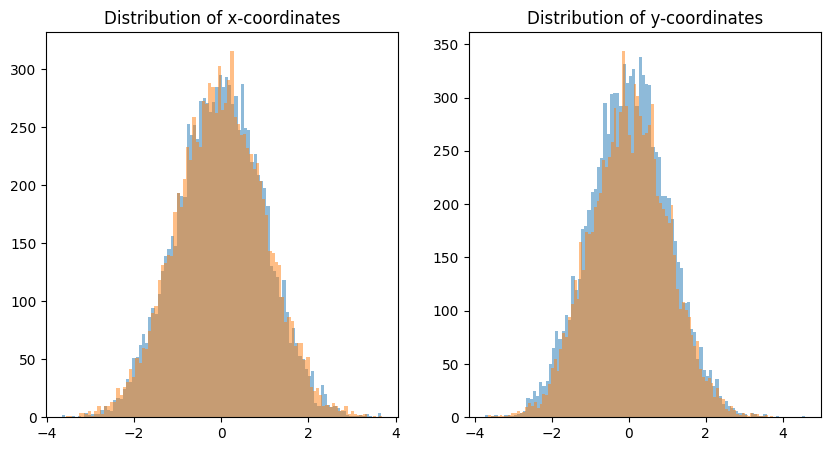

In [4]:
# Check distribution of coordinates

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(embedders_points[:, 0].detach().cpu().numpy(), bins=100, alpha=0.5, label='Product manifold')
axs[0].hist(hyperdt_points[:, 1], bins=100, alpha=0.5, label='Wrapped normal')
axs[0].set_title('Distribution of x-coordinates')

axs[1].hist(embedders_points[:, 1].detach().cpu().numpy(), bins=100, alpha=0.5, label='Product manifold')
axs[1].hist(hyperdt_points[:, 2], bins=100, alpha=0.5, label='Wrapped normal')
axs[1].set_title('Distribution of y-coordinates')

torch.Size([10000, 3]) (10000, 3)


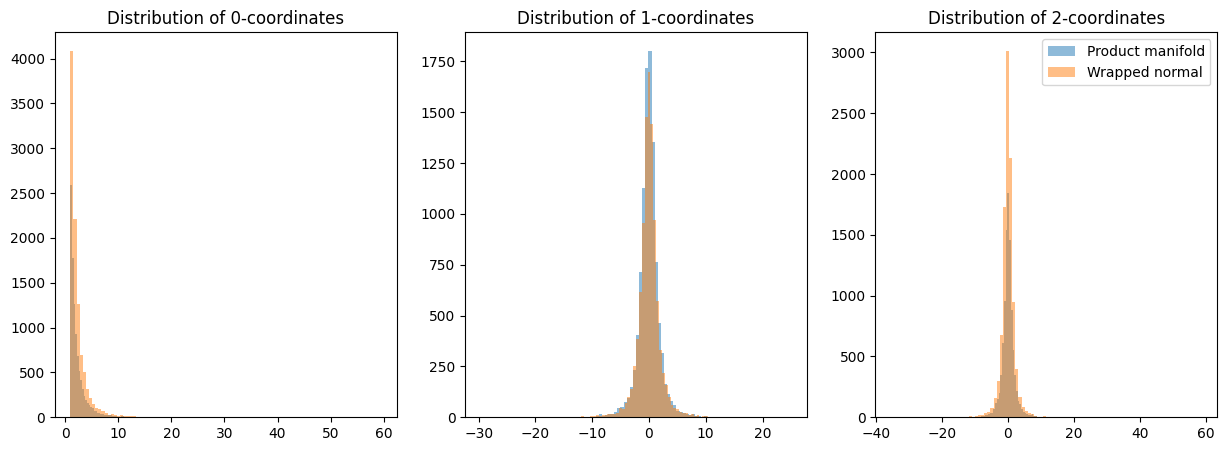

In [5]:
# Try a hyperboloid

def check_curvature(curvature, dims=2):
    pm = embedders.manifolds.ProductManifold(signature=[(curvature, dims)])
    embedders_points = pm.sample(torch.stack([pm.mu0] * 10_000))
    embedders_points = embedders_points / np.sqrt(np.abs(curvature))

    wn = hyperdt.wrapped_normal_all_curvature.WrappedNormalMixture(10_000, 1, curvature=curvature)
    hyperdt_points = wn.sample_points(
        means=pm.mu0.detach().numpy().reshape(1,-1), 
        covs=np.eye(pm.dim).reshape(1, pm.dim, pm.dim), 
        classes=[0]*10_000
    )

    print(embedders_points.shape, hyperdt_points.shape)

    # Check distribution of coordinates
    fig, axs = plt.subplots(1, pm.ambient_dim, figsize=(pm.ambient_dim * 5, 5))
    for i in range(3):
        axs[i].hist(embedders_points[:, i].detach().cpu().numpy(), bins=100, alpha=0.5, label='Product manifold')
        axs[i].hist(hyperdt_points[:, i], bins=100, alpha=0.5, label='Wrapped normal')
        axs[i].set_title(f'Distribution of {i}-coordinates')
    plt.legend()
    plt.show()

check_curvature(-1, 2)


torch.Size([10000, 3]) (10000, 3)


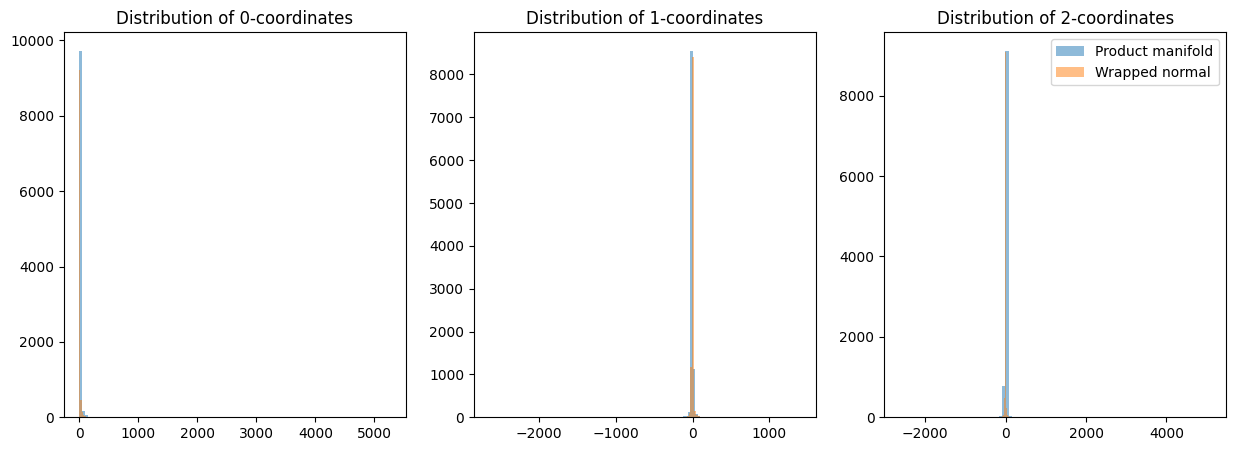

In [6]:
check_curvature(-4, 2)


torch.Size([10000, 3]) (10000, 3)


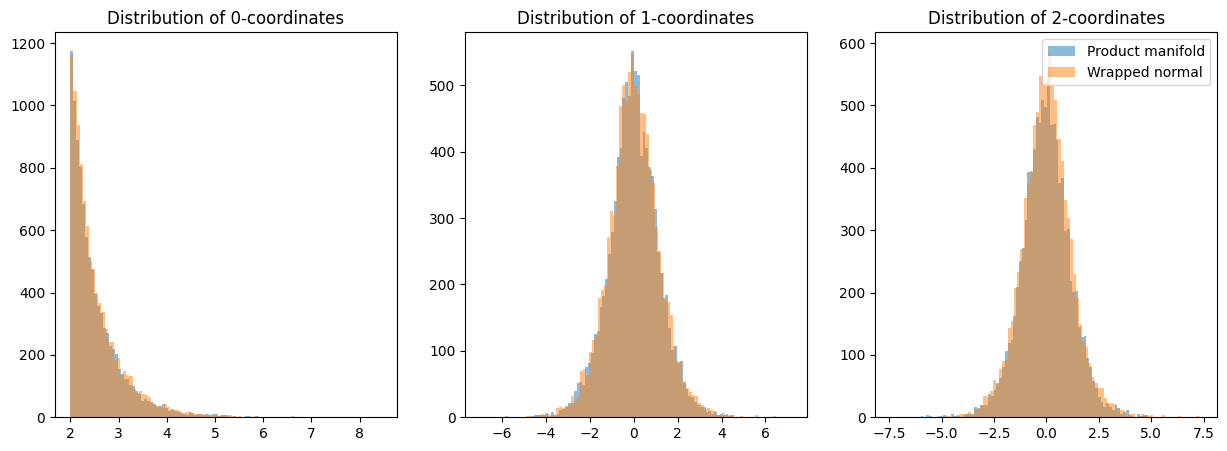

In [7]:
check_curvature(-0.25, 2)


torch.Size([10000, 3]) (10000, 3)


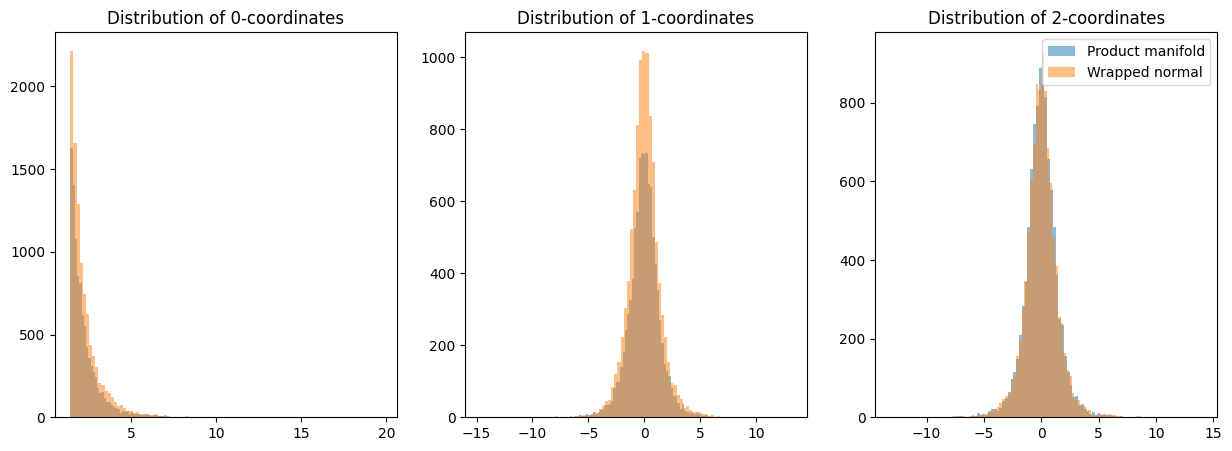

In [8]:
check_curvature(-0.5, 2)


torch.Size([10000, 3]) (10000, 3)


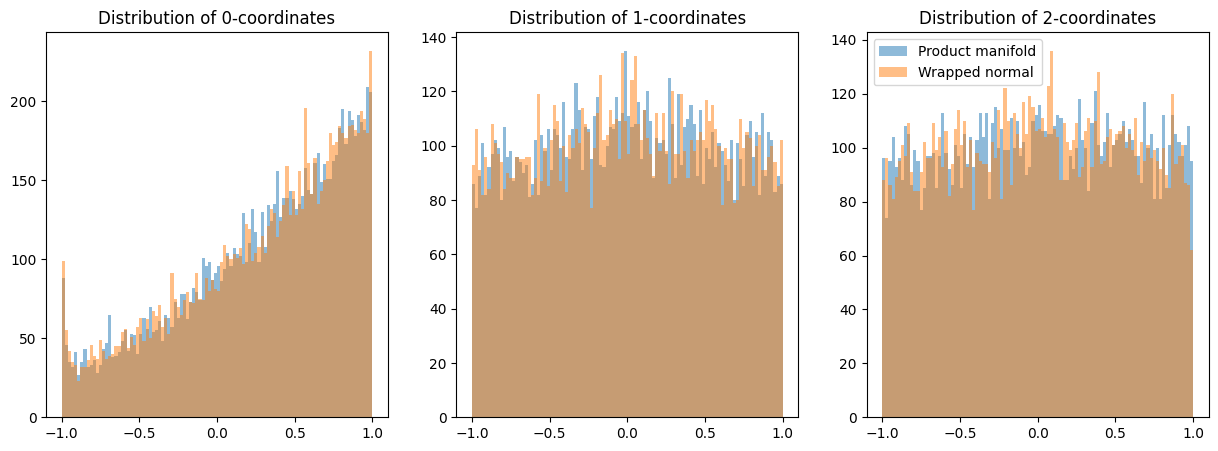

In [9]:
check_curvature(1, 2)

torch.Size([10000, 3]) (10000, 3)


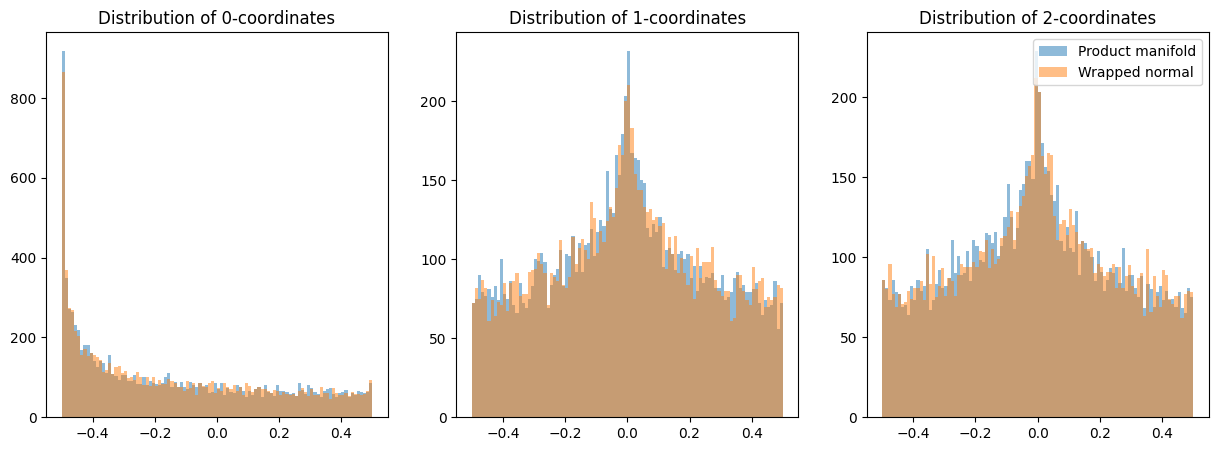

In [10]:
check_curvature(4, 2)

torch.Size([10000, 3]) (10000, 3)


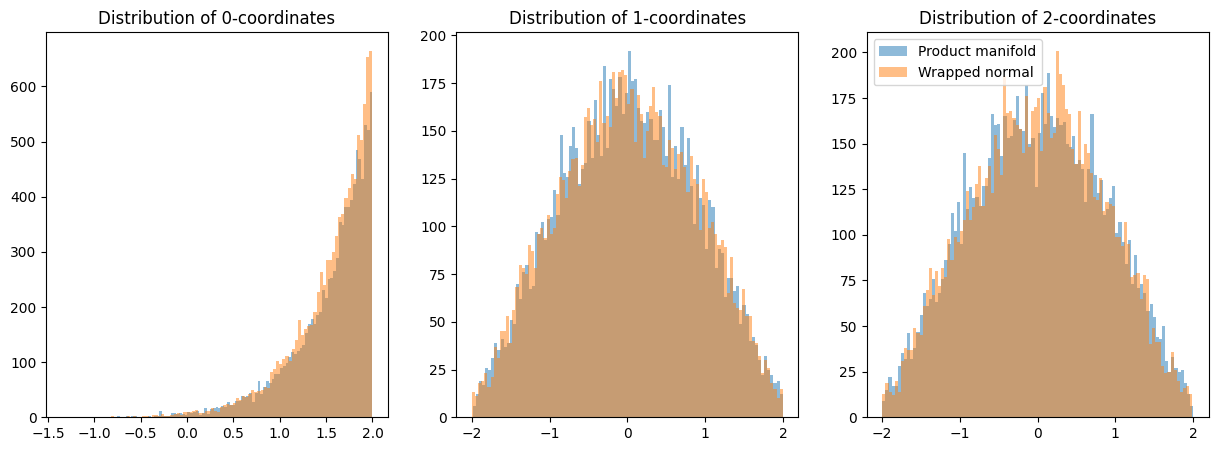

In [11]:
check_curvature(.25, 2)

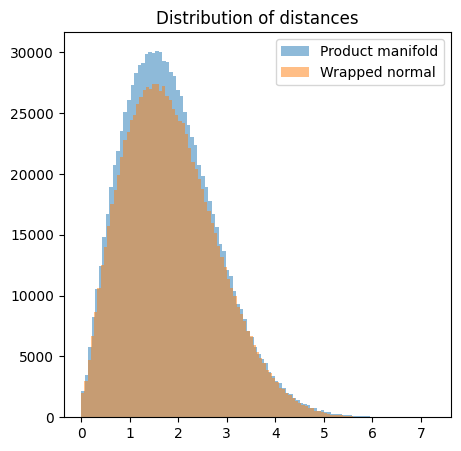

In [29]:
# Try a hyperboloid

def check_pdist(curvature, dims=2):
    pm = embedders.manifolds.ProductManifold(signature=[(curvature, dims)])
    embedders_points = pm.sample(torch.stack([pm.mu0] * 1_000))

    wn = hyperdt.wrapped_normal_all_curvature.WrappedNormalMixture(1_000, 1, curvature=curvature)
    hyperdt_points = wn.sample_points(
        means=pm.mu0.detach().numpy().reshape(1,-1), 
        covs=np.eye(pm.dim).reshape(1, pm.dim, pm.dim), 
        classes=[0]*1_000
    )

    embedders_dists = pm.pdist(embedders_points)
    hyperdt_dists = pm.pdist(torch.tensor(hyperdt_points) * np.sqrt(np.abs(curvature)))

    # Check distribution of coordinates
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(embedders_dists.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='Product manifold')
    ax.hist(hyperdt_dists.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='Wrapped normal')
    ax.set_title(f'Distribution of distances')
    plt.legend()
    plt.show()

check_pdist(-1, 2)


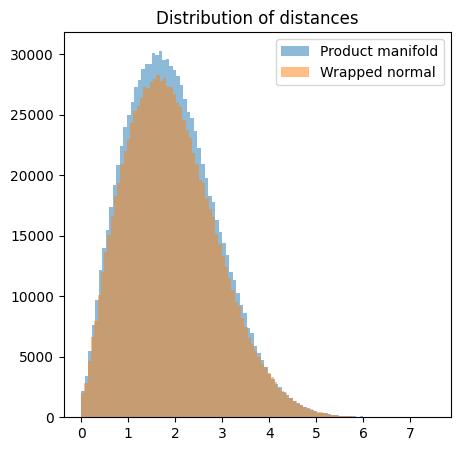

In [30]:
check_pdist(-2, 2)

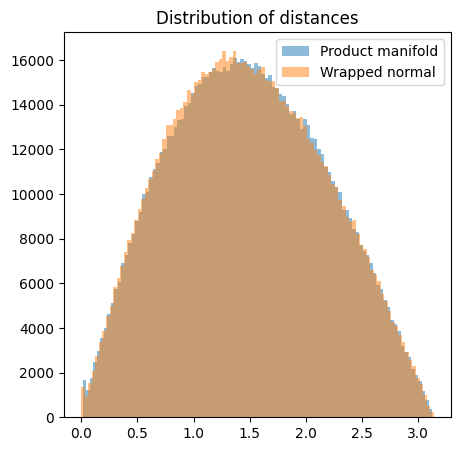

In [31]:
check_pdist(1, 2)

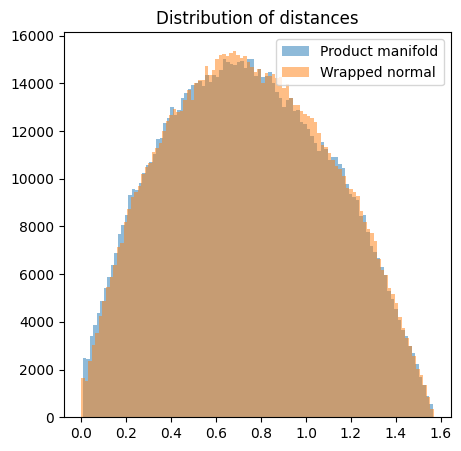

In [32]:
check_pdist(4, 2)

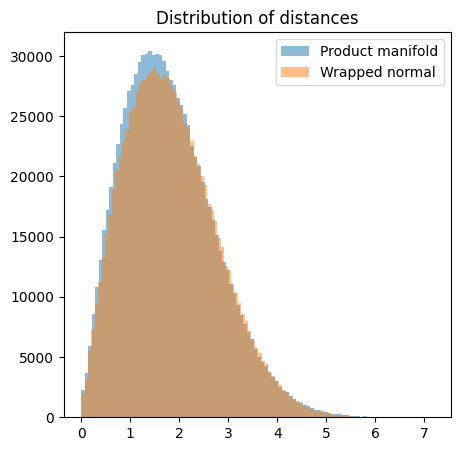

In [33]:
check_pdist(-.25, 2)

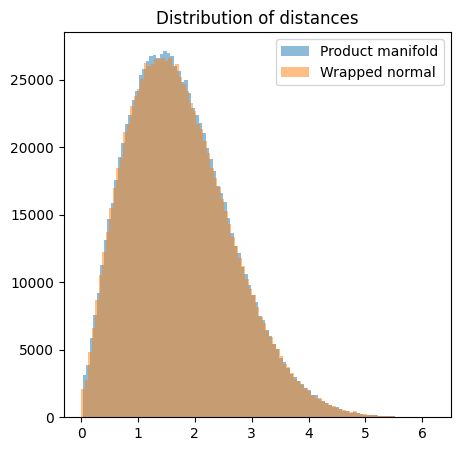

In [34]:
check_pdist(.25, 2)

In [43]:
# Try a hyperboloid

def check_signature(signature):
    pm = embedders.manifolds.ProductManifold(signature=signature)
    embedders_points = pm.sample(torch.stack([pm.mu0] * 1_000))

    ps = hyperdt.product_space_DT.ProductSpace(signature=[(dim, curvature) for (curvature, dim) in signature])
    ps.sample_clusters(1_000, num_classes=1, cov_scale=1, means=pm.mu0.detach().cpu().numpy().reshape(1,-1))
    hyperdt_points = ps.X

    embedders_dists = pm.pdist(embedders_points)
    hyperdt_dists = pm.pdist(torch.tensor(hyperdt_points))

    # Check distribution of coordinates
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(embedders_dists.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='Product manifold')
    ax.hist(hyperdt_dists.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='Wrapped normal')
    ax.set_title(f'Distribution of distances')
    plt.legend()
    plt.show()

check_signature([(1, 2), (1, 2)])

ValueError: shapes (3,) and (6,1000) not aligned: 3 (dim 0) != 6 (dim 0)

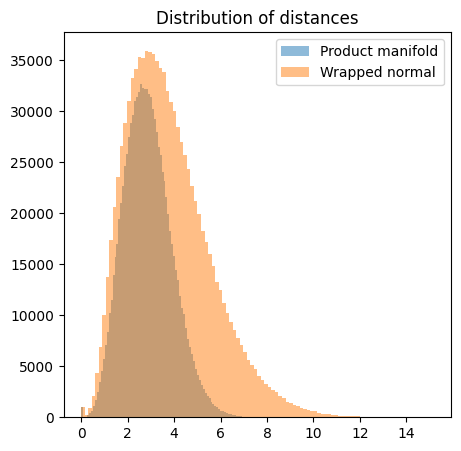

In [39]:
check_signature([(-1, 2), (-1, 2)])

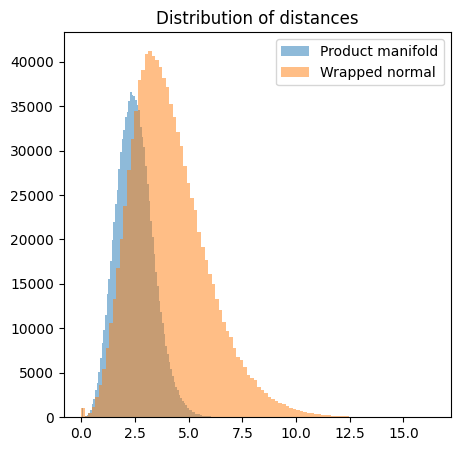

In [40]:
check_signature([(-1, 2), (1, 2)])

In [ ]:
# Ok, so this looks like the likely culprit
# TODO: get to the bottom of why product manifold distances start to disbehave like this